In [202]:
import numpy as np
import csv

outE = open('liquidargondata/firsttherm/E.csv', 'w+')
outE.write('n,Un,Kn\n')
xfile = open('liquidargondata/firsttherm/x.csv', 'w+', newline='')
xwr = csv.writer(xfile)
yfile = open('liquidargondata/firsttherm/y.csv', 'w+', newline='')
ywr = csv.writer(yfile)
zfile = open('liquidargondata/firsttherm/z.csv', 'w+', newline='')
zwr = csv.writer(zfile)
vxfile = open('liquidargondata/firsttherm/vx.csv', 'w+', newline='')
vxwr = csv.writer(vxfile)
vyfile = open('liquidargondata/firsttherm/vy.csv', 'w+', newline='')
vywr = csv.writer(vyfile)
vzfile = open('liquidargondata/firsttherm/vz.csv', 'w+', newline='')
vzwr = csv.writer(vzfile)

N = 864
rho = 0.75
L = (N/rho) ** (1./3.)
tau = 0.032

#all particles start at rest
vxn0 = np.zeros(N) #v_x_n
vxn1 = np.zeros(N) #v_x_n+1/2
vyn0 = np.zeros(N)
vyn1 = np.zeros(N)
vzn0 = np.zeros(N)
vzn1 = np.zeros(N)

#particles start at regular intervals
xn0 = []
yn0 = []
zn0 = []
for i in np.linspace(0., L-1.05, 9):
    for j in np.linspace(0., L-1.05, 10):
        for k in np.linspace(0., L-1.05, 10):
            xn0.append(i)
            yn0.append(j)
            zn0.append(k)
xn0 = np.array(xn0[:N])
yn0 = np.array(yn0[:N])
zn0 = np.array(zn0[:N])
xn1 = np.zeros(N)
yn1 = np.zeros(N)
zn1 = np.zeros(N)

fxn = np.zeros(N)
fyn = np.zeros(N)
fzn = np.zeros(N)

r = np.zeros((N, N))
ximagelocs = np.zeros((N, N))
yimagelocs = np.zeros((N, N))
zimagelocs = np.zeros((N, N))

def relax(x, y, z):
    Fstep(x, y, z)
    x = (x + 0.05*fxn) % L
    y = (y + 0.05*fyn) % L
    z = (z + 0.05*fzn) % L
    return x, y, z

def Fstep(xin, yin, zin):
    xx = np.repeat(xin, N).reshape(N, N)
    yy = np.repeat(yin, N).reshape(N, N)
    zz = np.repeat(zin, N).reshape(N, N)
    images = []
    for ximage in (-1, 0, 1):
        for yimage in (-1, 0, 1):
            for zimage in (-1, 0, 1):
                images.append((xx-xx.T+L*ximage)**2 + (yy-yy.T+L*yimage)**2 + (zz-zz.T+L*zimage)**2)
    global r, ximagelocs, yimagelocs, zimagelocs
    r = np.sqrt(np.minimum.reduce(images))
    ximagelocs = np.argmin(images, axis=0) // 9 - 1
    yimagelocs = np.argmin(images, axis=0) % 9 // 3 - 1
    zimagelocs = np.argmin(images, axis=0) % 3 - 1
    #r-dependent term in the force expression; couldn't decide what to call it, so just went with 'a'
    a = np.nan_to_num((1/r)**14 - 0.5*(1/r)**8)
    bx = (xin*a).T
    by = (yin*a).T
    bz = (zin*a).T
    for i in range(N):
        fxn[i] = np.sum(bx[i]) - np.dot(xin - ximagelocs[i]*L, a[i])
        fyn[i] = np.sum(by[i]) - np.dot(yin - yimagelocs[i]*L, a[i])
        fzn[i] = np.sum(bz[i]) - np.dot(zin - zimagelocs[i]*L, a[i])

#step forward the r=(x,y,z) values
def rstep(xin, yin, zin, vxin, vyin, vzin):
    xout = (xin + vxin*tau + fxn*(tau**2)/2) % L
    yout = (yin + vyin*tau + fyn*(tau**2)/2) % L
    zout = (zin + vzin*tau + fzn*(tau**2)/2) % L
    return xout, yout, zout

#step forward the v=(vx, vy, vz) values
def vstep(vxin, vyin, vzin):
    vxout = vxin + fxn * (tau/2)
    vyout = vyin + fyn * (tau/2)
    vzout = vzin + fzn * (tau/2)
    return vxout, vyout, vzout

def U():
    u0 = r**(-12)
    u0[u0 == np.inf] = 0
    u1 = r**(-6)
    u1[u1 == np.inf] = 0
    return 4*(np.sum(u0) - np.sum(u1))/2

def K(vxin, vyin, vzin):
    return 24 * np.sum(vxin**2 + vyin**2 + vzin**2)

def writevals(iteration):
    if iteration % 2 == 0:
        xwr.writerow(xn0)
        ywr.writerow(yn0)
        zwr.writerow(zn0)
    else:
        xwr.writerow(xn1)
        ywr.writerow(yn1)
        zwr.writerow(zn1)
    vxwr.writerow(vxn0)
    vywr.writerow(vyn0)
    vzwr.writerow(vzn0)

iterations = 1000
Fstep(xn0, yn0, zn0) #set F_0
for iteration in range(iterations):
    if iteration % 10 == 0:
        print(iteration)
        ue = U() #calculate U_{n} from r_{n}
        ke = K(vxn0, vyn0, vzn0) #calculate K_{n} from v_{n}
        print(f'U = {ue}, K = {ke}')
        outE.write(str(iteration) + ',' + str(ue) + ',' + str(ke) + '\n')
        writevals(iteration)
        
    vxn1, vyn1, vzn1 = vstep(vxn0, vyn0, vzn0) #set v_{n} -> v_{n+1/2}
    if iteration % 2 == 0:
        xn1, yn1, zn1 = rstep(xn0, yn0, zn0, vxn0, vyn0, vzn0) #set r_{n} -> r_{n+1}
        Fstep(xn1, yn1, zn1) #set F_{n} -> F_{n+1}
    else:
        xn0, yn0, zn0 = rstep(xn1, yn1, zn1, vxn0, vyn0, vzn0) #set r_{n} -> r_{n+1}
        Fstep(xn0, yn0, zn0) #set F_{n} -> F_{n+1}
    vxn0, vyn0, vzn0 = vstep(vxn1, vyn1, vzn1) #set v_{n+1/2} -> v_{n+1}

outE.close()
xfile.close()
yfile.close()
zfile.close()
vxfile.close()
vyfile.close()
vzfile.close()

C:\Users\Joheen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:80: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\Joheen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:80: RuntimeWarning: invalid value encountered in subtract


0
U = -4335.16931582246, K = 0.0


C:\Users\Joheen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:104: RuntimeWarning: divide by zero encountered in power
C:\Users\Joheen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:106: RuntimeWarning: divide by zero encountered in power


10
U = -4347.233053062751, K = 12.047437955122769
20
U = -4364.6451776446065, K = 29.454060099782744
30
U = -4374.638902644883, K = 39.45188263151174
40
U = -4380.423012445763, K = 45.23843378115528
50
U = -4385.967215920541, K = 50.78454460060827
60
U = -4394.874960055609, K = 59.693134641187456
70
U = -4407.97807736649, K = 72.78936175573016
80
U = -4416.926369196817, K = 81.73484188898126
90
U = -4422.109614037215, K = 86.93296486040587
100
U = -4440.716972749298, K = 105.52667907931314
110
U = -4459.4317158584, K = 124.2369202776114
120
U = -4477.426449979917, K = 142.23613224773572
130
U = -4491.531933647098, K = 156.30769498779856
140
U = -4519.067567767729, K = 183.78916173789688
150
U = -4521.326920983915, K = 186.15263776262424
160
U = -4559.200379225072, K = 223.92596929614854
170
U = -4573.230906712419, K = 237.99583569623957
180
U = -4619.042882370527, K = 283.7567822903152
190
U = -4668.665455252093, K = 333.39110953238963
200
U = -4718.306830735063, K = 383.0310955739118


In [203]:
import matplotlib.pyplot as plt
import pandas as pd
df = pd.read_csv('E.csv', index_col='n')
df

,Un,Kn
n,,
0,-4335.169316,0.000000
10,-4347.233053,12.047438
20,-4364.645178,29.454060
30,-4374.638903,39.451883
40,-4380.423012,45.238434
...,...,...
950,-4966.835217,631.447615
960,-4955.741606,620.346006
970,-4953.909420,618.545703


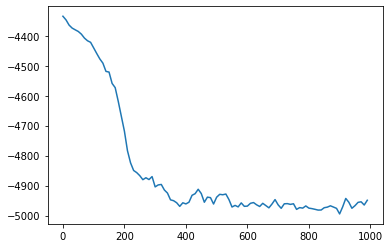

In [204]:
plt.plot(df['Un'])

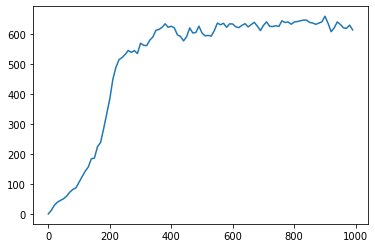

In [205]:
plt.plot(df['Kn'])

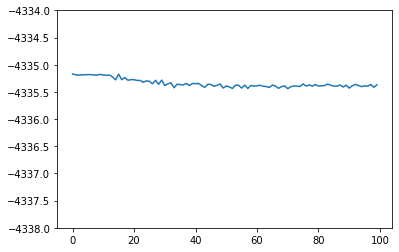

In [215]:
plt.ylim(-4338, -4334)
plt.plot(np.array(df['Un']) + np.array(df['Kn']))

In [218]:
T = K(vxn0, vyn0, vzn0) * (2/3) / N
T
#we find the temperature is too low (we want T = 1.069), so we rescale the velocities after thermalization and rerun

0.46898729492697666

In [219]:
1.069 * N * (3/2)

1385.424

In [222]:
#reads in the values from where the simulation ended
with open('liquidargondata/firsttherm/x.csv', newline='') as xfile:
    xn0 = np.array(list(csv.reader(xfile))[-1], dtype=np.float64)
with open('liquidargondata/firsttherm/y.csv', newline='') as yfile:
    yn0 = np.array(list(csv.reader(yfile))[-1], dtype=np.float64)
with open('liquidargondata/firsttherm/z.csv', newline='') as zfile:
    zn0 = np.array(list(csv.reader(zfile))[-1], dtype=np.float64)
with open('liquidargondata/firsttherm/vx.csv', newline='') as vxfile:
    vxn0 = np.array(list(csv.reader(vxfile))[-1], dtype=np.float64)
with open('liquidargondata/firsttherm/vy.csv', newline='') as vyfile:
    vyn0 = np.array(list(csv.reader(vyfile))[-1], dtype=np.float64)
with open('liquidargondata/firsttherm/vz.csv', newline='') as vzfile:
    vzn0 = np.array(list(csv.reader(vzfile))[-1], dtype=np.float64)

outE = open('liquidargondata/secondtherm/E.csv', 'w+')
outE.write('n,Un,Kn\n')
xfile = open('liquidargondata/secondtherm/x.csv', 'w+', newline='')
xwr = csv.writer(xfile)
yfile = open('liquidargondata/secondtherm/y.csv', 'w+', newline='')
ywr = csv.writer(yfile)
zfile = open('liquidargondata/secondtherm/z.csv', 'w+', newline='')
zwr = csv.writer(zfile)
vxfile = open('liquidargondata/secondtherm/vx.csv', 'w+', newline='')
vxwr = csv.writer(vxfile)
vyfile = open('liquidargondata/secondtherm/vy.csv', 'w+', newline='')
vywr = csv.writer(vyfile)
vzfile = open('liquidargondata/secondtherm/vz.csv', 'w+', newline='')
vzwr = csv.writer(vzfile)

vxn0 = vxn0 * np.sqrt(2) #rescale the velocities to increase KE and T
vyn0 = vyn0 * np.sqrt(2)
vzn0 = vzn0 * np.sqrt(2)

iterations = 500
Fstep(xn0, yn0, zn0) #set F_0
for iteration in range(iterations):
    if iteration % 10 == 0:
        print(iteration)
        ue = U() #calculate U_{n} from r_{n}
        ke = K(vxn0, vyn0, vzn0) #calculate K_{n} from v_{n}
        print(f'U = {ue}, K = {ke}')
        outE.write(str(iteration) + ',' + str(ue) + ',' + str(ke) + '\n')
        writevals(iteration)
        
    vxn1, vyn1, vzn1 = vstep(vxn0, vyn0, vzn0) #set v_{n} -> v_{n+1/2}
    if iteration % 2 == 0:
        xn1, yn1, zn1 = rstep(xn0, yn0, zn0, vxn0, vyn0, vzn0) #set r_{n} -> r_{n+1}
        Fstep(xn1, yn1, zn1) #set F_{n} -> F_{n+1}
    else:
        xn0, yn0, zn0 = rstep(xn1, yn1, zn1, vxn0, vyn0, vzn0) #set r_{n} -> r_{n+1}
        Fstep(xn0, yn0, zn0) #set F_{n} -> F_{n+1}
    vxn0, vyn0, vzn0 = vstep(vxn1, vyn1, vzn1) #set v_{n+1/2} -> v_{n+1}

outE.close()
xfile.close()
yfile.close()
zfile.close()
vxfile.close()
vyfile.close()
vzfile.close()

C:\Users\Joheen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:80: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\Joheen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:80: RuntimeWarning: invalid value encountered in subtract


0


C:\Users\Joheen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:104: RuntimeWarning: divide by zero encountered in power
C:\Users\Joheen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:106: RuntimeWarning: divide by zero encountered in power


U = -4948.759763323499, K = 1226.7796720507008
10
U = -4768.496966919925, K = 1046.847844221276
20
U = -4719.257041826732, K = 997.4477823346997


KeyboardInterrupt: 

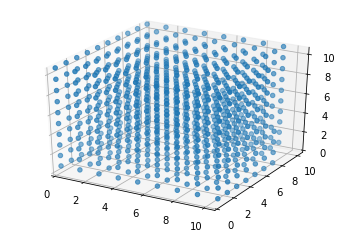

In [129]:
#starting configuration
import numpy as np
N = 864
rho = 0.75
L = (N/rho) ** (1./3.)
tau = 0.032

xn0 = []
yn0 = []
zn0 = []
for i in np.linspace(0, L, 9):
    for j in np.linspace(0.5, L, 10):
        for k in np.linspace(0.5, L, 10):
            xn0.append(i)
            yn0.append(j)
            zn0.append(k)
xn0 = np.array(xn0[:N])
yn0 = np.array(yn0[:N])
zn0 = np.array(zn0[:N])
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_xlim(0, L)
ax.set_ylim(0, L)
ax.set_zlim(0, L)

ax.scatter(xn0, yn0, zn0)